## phylogeny of global M. bovis lineages

* global https://www.frontiersin.org/articles/10.3389/fmicb.2020.00843/full

* UK https://www.ncbi.nlm.nih.gov/bioproject/PRJNA523164

In [1]:
import sys,os,shutil,subprocess
import glob,random
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
import seaborn as sns
from Bio import SeqIO
sys.path.append('pathogenie')
from snipgenie import tools, aligners, app, trees, plotting
import toytree

In [2]:
from IPython.display import Image
Image(url='https://www.frontiersin.org/files/Articles/509125/fmicb-11-00843-HTML/image_m/fmicb-11-00843-g003.jpg',width=700)

In [3]:
zimpel=pd.read_csv('/storage/btbgenie/mbovis_other/mbovis_genomes_zimpel.csv')
zimpel[:3]

,Country,Host,SRA ID,References
0,Brazil,capybara,SRR9850824,This study
1,Brazil,llama,SRR9850830,This study
2,Brazil,bison,SRR7693912,This study


In [4]:
countries = list(zimpel.Country.unique())

In [5]:
sub1 = zimpel.Country.value_counts()[7:-1]
sub1
selected1 = zimpel[zimpel.Country.isin(sub1.index)]

## sub-sample countries with many entries

In [6]:
sub2 = zimpel.Country.value_counts()[:7]
s2 = zimpel[zimpel.Country.isin(sub2.index)]
selected2=s2.groupby('Country').sample(2,random_state=2) 

## fetch data

In [ ]:
omit = ['SRR7693877','SRR7693912','SRR9850830','SRR5486090','SRR5486092','SRR7131025']
for sra in selected2['SRA ID']:
    print (sra)
    if sra in omit:
        continue
    f = glob.glob('/storage/btbgenie/mbovis_other/%s*.fastq*' %sra)
    if len(f)>0:
        continue
    cmd = 'fastq-dump --split-files -O /storage/btbgenie/mbovis_other %s' %sra
    subprocess.check_output(cmd, shell=True)
    cmd = 'pigz /storage/btbgenie/mbovis_other/%s*.fastq' %sra
    print (cmd)
    subprocess.check_output(cmd, shell=True)

In [ ]:
reload(app)
args = {'threads':20, 'outdir': '/storage/btbgenie/global_results', 'labelsep':'-',
        'input':['/storage/btbgenie/mbovis_other'],
         'species': 'Mbovis-AF212297', 'overwrite':False,
         'custom_filters': True,        
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

## spoligotypes

In [ ]:
def get_spoligotypes(samples):
    """Get spoligotypes for M.bovis strains"""
    
    samples = samples.drop_duplicates('sample')
    res=[]
    for i,r in samples.iterrows():       
        f=r.filename
        b = tools.get_spoligotype(f,1e6)
        sb = tools.get_sb_number(b)
        print (r['sample'],f, sb, b)
        res.append([r['sample'],f,sb,b])
    
    res = pd.DataFrame(res,columns=['sample','filename','SB','code'])
    return res

spotypes = get_spoligotypes(samples)
spotypes.to_csv('/storage/btbgenie/global_results/spotypes.csv')

## merge meta data

In [36]:
spotypes = pd.read_csv('/storage/btbgenie/global_results/spotypes.csv')
#spotypes['SB'] = spotypes.SB.fillna('-)
meta = zimpel.merge(spotypes,left_on='SRA ID',right_on='sample')
meta

,Country,Host,SRA ID,References,Unnamed: 0,sample,filename,SB,code
0,Brazil,capybara,SRR9850824,This study,18,SRR9850824,/storage/btbgenie/mbovis_other/SRR9850824_2.fa...,SB0295,1101111101111110111101111111111111110100000
1,Brazil,bovine,SRR6705904,"Zimpel et al., 2017",51,SRR6705904,/storage/btbgenie/mbovis_other/SRR6705904_1.fa...,SB0121,1101111101111110111101111111111111111100000
2,Canada,bovine,SRR7240109,"Orloski et al., 2018",47,SRR7240109,/storage/btbgenie/mbovis_other/SRR7240109_1.fa...,SB0673,0101101000001110111111111111111111111100000
3,Canada,bison,SRR6467887,"Andrievskaia et al., 2018",15,SRR6467887,/storage/btbgenie/mbovis_other/SRR6467887_1.fa...,SB0130,1101111101011110111111111111111111111100000
4,Canada,bovine,SRR1791768,USDA-NVSL-DBL,58,SRR1791768,/storage/btbgenie/mbovis_other/SRR1791768_2.fa...,SB0265,1101101101111110111101111111111111111100000
...,...,...,...,...,...,...,...,...,...
58,Uruguay,bovine,SRR5430746,"Lasserre et al., 2018",24,SRR5430746,/storage/btbgenie/mbovis_other/SRR5430746_1.fa...,SB1072,1101101000001110111111111101111111111100000
59,Uruguay,bovine,SRR5430750,"Lasserre et al., 2018",55,SRR5430750,/storage/btbgenie/mbovis_other/SRR5430750_2.fa...,SB0130,1101111101011110111111111111111111111100000
60,Uruguay,bovine,SRR5430747,"Lasserre et al., 2018",40,SRR5430747,/storage/btbgenie/mbovis_other/SRR5430747_2.fa...,SB0130,1101111101011110111111111111111111111100000
61,USA,deer,SRR5817677,"Bruning-Fann et al., 2017",4,SRR5817677,/storage/btbgenie/mbovis_other/SRR5817677_2.fa...,SB0145,1101000000000010111111111111111111111100000


In [37]:
clust = pd.read_csv('/storage/btbgenie/global_results/clusters.txt',sep='\t')
clust
meta = meta.merge(clust,left_on='SRA ID',right_on='SequenceName')

In [38]:
treefile = '/storage/btbgenie/global_results/RAxML_bipartitions.variants'
tre = toytree.tree(treefile)
#tre=tre.drop_tips(['SRR5486090', 'SRR5486092', 'SRR5486091', 'ref'])
mystyle = { "layout": 'r','node_sizes':1,'tip_labels_align':True}
#tre.draw(**mystyle,width=700);

In [ ]:
tre = tre.root(names=['SRR5486072'])
tipnames = tre.get_tip_labels()
mapping = dict(zip(meta['SRA ID'],meta.Country))
mapping['ref'] = 'AF2122/97'

tiplabels = [mapping[i] for i in tipnames]
#mapping = dict(zip(meta['SRA ID'],meta.SB))
mapping = dict(zip(meta['SRA ID'],meta.ClusterNumber))
colormap = trees.colors_from_labels(meta,'SRA ID','ClusterNumber')
tip_colors = [colormap[mapping[i]] if i in mapping else 'Black' for i in tipnames]
node_sizes=[0 if i else 8 for i in tre.get_node_values(None, 1, 0)]
node_colors = [colormap[mapping[n]] if n in mapping else 'black' for n in tre.get_node_values('name', True, True)]

canvas,t,r=tre.draw(layout='r',width=600,height=700,tip_labels=tiplabels,node_markers="o",node_hover=True,edge_widths=1,
         tip_labels_colors=tip_colors,node_sizes=node_sizes,scalebar=True,node_colors=node_colors)#tip_labels_align=True);

#leg = list(zip(tiplabels,colors))
#print (leg)
#canvas.legend(leg,corner=("top", 100, 100, 70));
import toyplot
toyplot.png.render(canvas, "/storage/btbgenie/global_results/tree_clusters.png")

## combine ireland + global samples in one tree

use subset of the Ireland samples to include in global tree

In [211]:
mapped = {'wicklow':'/storage/btbgenie/wicklow_results/mapped/',
           'monaghan':'/storage/btbgenie/monaghan/monaghan_results/mapped/',
           'NI':'/storage/btbgenie/NI_results/','global':'/storage/btbgenie/global_results/'}
reload(app)
bam_files=[]
for m in mapped:
    f = app.get_files_from_paths(mapped[m], '*.bam')
    #get sub-sample
    if m != 'global':
        f = random.sample(f,8)
    bam_files.extend(f)
print (len(bam_files))
outdir='/storage/btbgenie/combined_results'


84


'/storage/btbgenie/combined_results/samples.txt'

## run variant calling only on already mapped files

In [ ]:
gff_file=os.path.join(outdir,'mbovis.gff')
tools.gff_bcftools_format(app.mbovis_gb, gff_file)
app.run_bamfiles(bam_files, app.mbovis_genome, outdir='/storage/btbgenie/combined_results', threads=20,
                 mask=app.mbovis_mask, gff_file=gff_file,
                 custom_filters=True, overwrite=False)

In [214]:
treefile = '/storage/btbgenie/combined_results/RAxML_bipartitions.variants'
tre2 = toytree.tree(treefile)

In [ ]:
tre2.ladderize().draw(**mystyle,width=700);

## RD analysis

In [ ]:
from snipgenie import rdiff
rdiff.create_rd_index()
df = W.fastq_table
res = rdiff.find_regions(df,'/storage/btbgenie/global_results/rd_aligned',threads=20)
X = rdiff.get_matrix(res, cutoff=0.15)
X['ident'] = X.apply(rdiff.apply_rules,1)
X.to_csv('/storage/btbgenie/global_results/rd.csv')

In [ ]:
cols=['SRA ID','Country','SB','ClusterNumber']
X = pd.read_csv('/storage/btbgenie/global_results/rd.csv',index_col=0)
X = X.iloc[:,:-1]
X=X.merge(meta[cols],left_index=True,right_on='SRA ID').set_index(cols)

sns.clustermap(X,xticklabels=True,yticklabels=True,figsize=(12,12))
rvar = ['RD149','RD3','RD5','RD5oryx*','RD122','RDAf2']

rdv = X[rvar]

In [ ]:
names = tre.get_tip_labels()
names.reverse()
matrix = rdv.loc[names].values*255

In [672]:
# create a canvas
import toyplot
canvas = toyplot.Canvas(width=600, height=650);

# add tree
axes = canvas.cartesian(bounds=(50, 350, 20, 640))
tre.draw(axes=axes,node_colors=node_colors, #,tip_labels=tiplabels
         tip_labels_colors=tip_colors,node_sizes=node_sizes, tip_labels_align=True)

# add matrix
table = canvas.table(
    rows=len(rdv),
    columns=6,
    margin=0,
    bounds=(375, 450, 25, 630),  
)

colormap = toyplot.color.brewer.map("Blues")

# apply a color to each cell in the table
for ridx in range(matrix.shape[0]):
    for cidx in range(matrix.shape[1]):
        cell = table.cells.cell[ridx, cidx]
        cell.style = {
            "fill": colormap.colors(matrix[ridx, cidx], 0, 100),
        }

# style the gaps between cells
table.body.gaps.columns[:] = 3
table.body.gaps.rows[:] = 3

# hide axes coordinate



<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="600.0px" height="650.0px" viewBox="0 0 600.0 650.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tcd6f4ced37814c7facbec9d6ea502955"> SRR5216864 SRR6467891 ERR841833 ERR841811 SRR6045214 SRR6467885 SRR7240264 SRR7240109 SRR1791709 SRR5430746 SRR6467893 SRR6045806 SRR5817677 SRR1657070 SRR5657474 SRR5430098 SRR1657068 SRR1657061 SRR6467887 SRR5430747 SRR5430750 SRR5430569 ERR564390 SRR5196685 ERR1815541 ERR1815549 ERR550954 SRR1791768 SRR6467889 SRR9850824 SRR6705904 ERR551917 ERR551009 ERR550755 ERR502526 ERR502499 ERR2659160 ERR2659159 ERR1203064 ERR553061 ERR161044 ERR181980 ERR229952 ERR551252 SRR1791710 SRR1791712 ERR2659161 ERR2659162 SRR7131117 SRR7131025 SRR5486077 SRR4117155 SRR5486089 SRR5486093 SRR5486088 SRR5486087 SRR3085259 SRR5486076 SRR5486071 SRR5486072 -0.15 -0.10 -0.05 0.00 0.05 0 20 40 60

## SNPs and indels clustering

In [43]:
csq = app.read_csq_file('/storage/btbgenie/global_results/csq.tsv')
snp_mat = app.get_aa_snp_matrix(csq)

In [44]:
csqind = app.read_csq_file('/storage/btbgenie/global_results/csq_indels.tsv')
#print (csqind)
#print (csqind.snp_type.value_counts())

ind_mat = app.get_aa_snp_matrix(csqind)
ind_mat.reset_index().snp_type.value_counts()
ind_mat
ind_mat[ind_mat.sum(1)>5]

,,,sample,ERR1203064,ERR161044,ERR1815541,ERR1815549,ERR181980,ERR229952,ERR2659159,ERR2659160,ERR2659161,ERR2659162,...,"Warning: Skipping overlapping variants at LT708304.1:3893297, sample SRR5216864","Warning: Skipping overlapping variants at LT708304.1:3893297, sample SRR6467891","Warning: Skipping overlapping variants at LT708304.1:3897441, sample SRR1657070","Warning: Skipping overlapping variants at LT708304.1:3897441, sample SRR5657474","Warning: Skipping overlapping variants at LT708304.1:3897441, sample SRR5817677","Warning: Skipping overlapping variants at LT708304.1:55530, sample ERR553061","Warning: Skipping overlapping variants at LT708304.1:969436, sample SRR9850824","Warning: Skipping overlapping variants at LT708304.1:977362, sample SRR5486071","Warning: Skipping overlapping variants at LT708304.1:977362, sample SRR5486072","Warning: Skipping overlapping variants at LT708304.1:977362, sample SRR6045214"
start,gene,aa,snp_type,,,,,,,,,,,,,,,,,,,,,
39207.0,BQ2027_MB0037c,202GPSDAAQRVTGSAEDFCFLVTQRRALSTLDVNAVGEDAQRWLTIAQAFAGPPGRGR*>202GHPMRPSGSPGPPRTSASWSPSGAR*,frameshift,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
55517.0,ponA1,766V>766VP,inframe_insertion,1,1,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
55518.0,ponA1,766V>767VP,inframe_insertion,1,0,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
55521.0,ponA1,767P>769PP,inframe_insertion,1,0,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
55524.0,ponA1,768P>771PP,inframe_insertion,1,0,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4161552.0,lipE,387GKPGRDPEAGRYGALLNAITAEIPRASSG*>387GNPVGTPRLGATAPC*,frameshift,1,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4227771.0,chp1,122GLNSPTVGSSVSAGTNNLDAAIRSTDGPIFVAGLSQGTLVLDREQARLANDPTAPPPGQLTFIKAGDPNNLLWRAFRPGTHVPIIDYTVPAPVESQYDTINIVGQYDIFSDPPNRPGNLLADLNAIAAGGYYGHSATAFSDPARVAPRDITTTTNSLGATTTTYFIRTDQLPLVRALVDMAGLPPQAAGTVDAALRPIIDRAYQPGPAPAVNPRDLVQGIRGIPAIAPAIAIPIGSTTGASAATSTAAATAAATNALRGANVGPGANKALSMVRGLLPKGKKH*>122G*,frameshift,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4298007.0,espj,195EKPATEQAEPVHEVTNDDQGDQGDVQPAEVVAAARDEGAGASPGQQPGGGVPAQAMDTGAGARPAASPLAAPVDPSTPAPSTTTTL*>195ENRPPSKRSRSTK*,frameshift,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
mat = snp_mat
#mat.index = mat.index.get_level_values(1)+'_'+mat.index.get_level_values(2)
stat = mat.sum(1).reset_index()
#stat.gene.value_counts()[:30]

In [61]:
C=mat.T
C=C.merge(meta[cols],left_index=True,right_on='SRA ID').set_index(cols).T
C=C[C.sum(1)>3].T
C.iloc[:4,:2]

/usr/local/lib/python3.8/dist-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (4 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


,,,,"(1057, dnaA, 353I>353V, missense)","(4480, BQ2027_MB0004, 16L>16S, missense)"
SRA ID,Country,SB,ClusterNumber,,
ERR1203064,Ghana,SB2277,7,1,1
ERR161044,Malawi,SB2277,9,1,1
ERR1815541,South Africa,SB0121,5,1,1
ERR1815549,South Africa,SB0121,5,1,1


In [62]:
countries = C.index.get_level_values(1)
sb = C.index.get_level_values(2)
clust = C.index.get_level_values(3)

/usr/local/lib/python3.8/dist-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


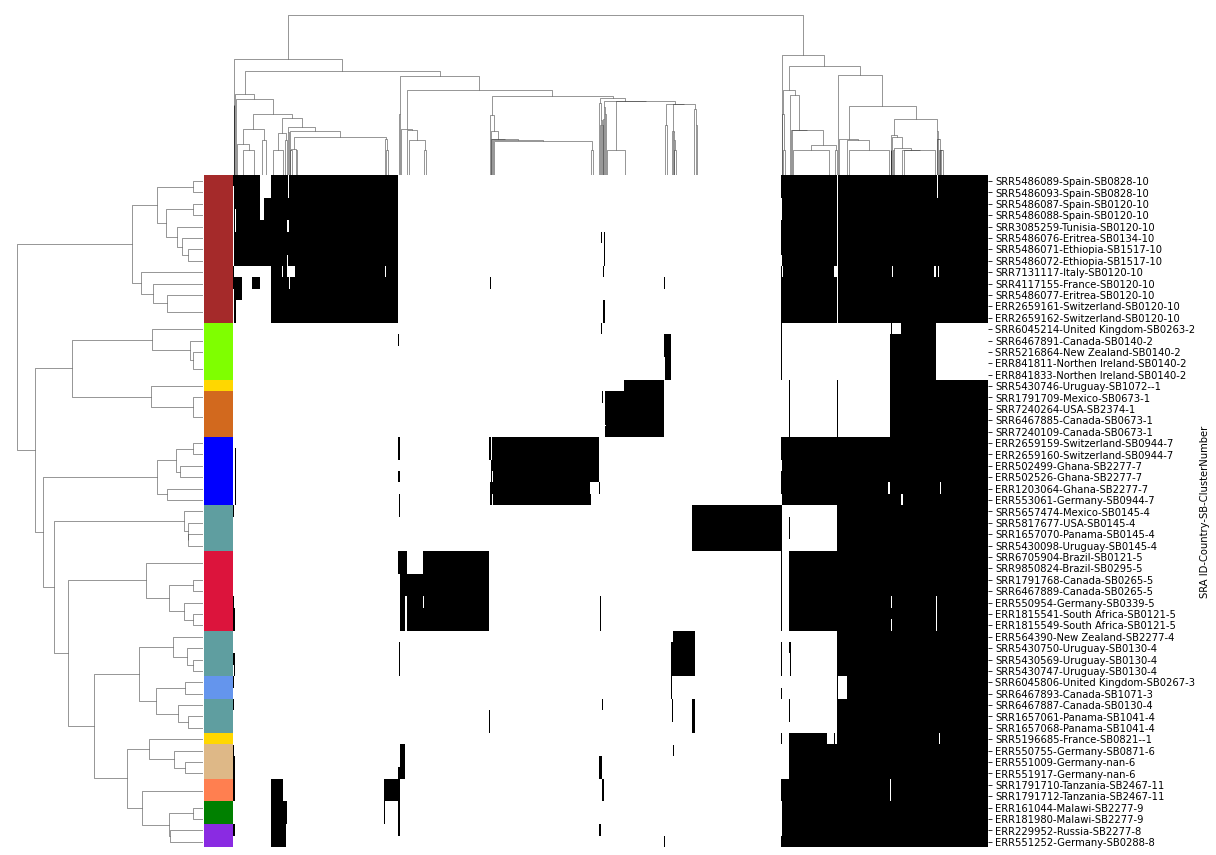

In [63]:
reload(trees)
colormap1 = dict(zip(sb.unique(), trees.qcolors))
colors1 = [colormap1[i] if i in colormap1 else 'Black' for i in sb]

colormap2 = dict(zip(clust.unique(), trees.qcolors))
colors2 = [colormap2[i] if i in colormap2 else 'Black' for i in clust]
#print (colors2)

g=sns.clustermap(C,xticklabels=False,yticklabels=True,figsize=(17,12),cmap='gray_r',cbar_pos=None,row_colors=colors2)
g.fig.savefig('/storage/btbgenie/global_results/indel_clusters.jpg')

## PCA snps

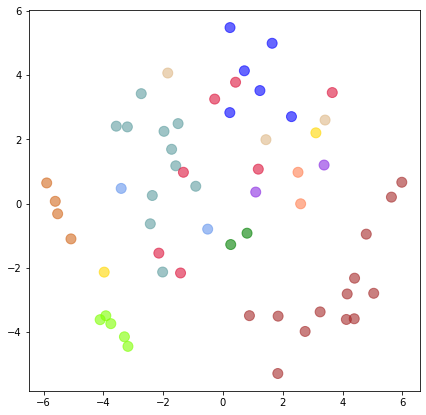

In [59]:
import sklearn
from sklearn import decomposition
from sklearn import manifold

pca = decomposition.PCA(n_components=3)
mds = manifold.MDS(n_components=3)
pos = mds.fit(C).embedding_
X = pca.fit_transform(pos)
#X = pca.transform(C)

fig,ax = plt.subplots(figsize=(7, 7))
ax.scatter(X[:, 0], X[:, 1], c=colors2, s=100, alpha=.6)
